In [1]:
# @title
!pip install sentence-transformers ragas datasets langchain langchain-community pandas matplotlib seaborn requests==2.32.4 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/73.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.6/486.6 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.6/303.6 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.6/503.6 kB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.7/146.7 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.2/208.2 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.5/155.5 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.6/948.6 kB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 20.0 MB/s eta 0:00:00


In [6]:

# Load all required Libraries
import pandas as pd
import transformers, torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoModelForCausalLM
from datasets import Dataset
import faiss

# Read Passages from the Datasets and Drop rows if they are NA or empty

In [7]:
passages = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-wikipedia/data/passages.parquet/part.0.parquet")

print(passages.shape)
passages.head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


(3200, 1)


,passage
id,
0,"Uruguay (official full name in ; pron. , Eas..."
1,"It is bordered by Brazil to the north, by Arge..."
2,Montevideo was founded by the Spanish in the e...
3,The economy is largely based in agriculture (m...
4,"According to Transparency International, Urugu..."


# Do EDA on the passage dataset
- You can try to find the maximum and minimum length of the passages before indexing (just a direction)

In [6]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [7]:
print("\n1. DATASET STRUCTURE")
print("-" * 70)
print(f"Shape: {passages.shape}")
print(f"Columns: {passages.columns.tolist()}")
print(f"\nData types:\n{passages.dtypes}")
print(f"\nIndex info: {passages.index.name} (range: {passages.index.min()} to {passages.index.max()})")


1. DATASET STRUCTURE
----------------------------------------------------------------------
Shape: (3200, 1)
Columns: ['passage']

Data types:
passage    string[python]
dtype: object

Index info: id (range: 0 to 3200)


In [8]:
print("\n2. MISSING VALUES CHECK")
print("-" * 70)
null_count = passages.isnull().sum()
print(f"Null values in 'passage' column: {null_count['passage']}")
print(f"Percentage: {(null_count['passage'] / len(passages) * 100):.2f}%")

# Check for empty strings
empty_count = (passages['passage'] == '').sum()
print(f"\nEmpty string passages: {empty_count}")

# Check for very short passages (< 10 characters - likely low quality)
very_short = (passages['passage'].str.len() < 10).sum()
print(f"Very short passages (< 10 chars): {very_short}")



2. MISSING VALUES CHECK
----------------------------------------------------------------------
Null values in 'passage' column: 0
Percentage: 0.00%

Empty string passages: 0
Very short passages (< 10 chars): 39


In [9]:
print("\n3. PASSAGE LENGTH ANALYSIS")
print("-" * 70)

# Calculate character lengths
passages['char_length'] = passages['passage'].str.len()

# Estimate token count (rough approximation: 1 token ≈ 4 characters)
# This is important because embedding models have token limits (typically 512)
passages['estimated_tokens'] = passages['char_length'] / 4

print("\nCHARACTER LENGTH STATISTICS:")
print(f"  Minimum: {passages['char_length'].min()}")
print(f"  Maximum: {passages['char_length'].max()}")
print(f"  Mean: {passages['char_length'].mean():.2f}")
print(f"  Median: {passages['char_length'].median():.2f}")
print(f"  Std Dev: {passages['char_length'].std():.2f}")

print("\nESTIMATED TOKEN STATISTICS:")
print(f"  Minimum: {passages['estimated_tokens'].min():.0f}")
print(f"  Maximum: {passages['estimated_tokens'].max():.0f}")
print(f"  Mean: {passages['estimated_tokens'].mean():.2f}")
print(f"  Median: {passages['estimated_tokens'].median():.2f}")

# Important: Check how many passages exceed common token limits
print("\nTOKEN LIMIT ANALYSIS:")
print(f"  Passages > 512 tokens: {(passages['estimated_tokens'] > 512).sum()} ({(passages['estimated_tokens'] > 512).sum() / len(passages) * 100:.1f}%)")
print(f"  Passages > 384 tokens: {(passages['estimated_tokens'] > 384).sum()} ({(passages['estimated_tokens'] > 384).sum() / len(passages) * 100:.1f}%)")
print(f"  Passages > 256 tokens: {(passages['estimated_tokens'] > 256).sum()} ({(passages['estimated_tokens'] > 256).sum() / len(passages) * 100:.1f}%)")

print("\n all-MiniLM-L6-v2 has a 256 token limit. Longer passages will be truncated.")



3. PASSAGE LENGTH ANALYSIS
----------------------------------------------------------------------

CHARACTER LENGTH STATISTICS:
  Minimum: 1
  Maximum: 2515
  Mean: 389.85
  Median: 299.00
  Std Dev: 348.37

ESTIMATED TOKEN STATISTICS:
  Minimum: 0
  Maximum: 629
  Mean: 97.46
  Median: 74.75

TOKEN LIMIT ANALYSIS:
  Passages > 512 tokens: 7 (0.2%)
  Passages > 384 tokens: 29 (0.9%)
  Passages > 256 tokens: 177 (5.5%)

 all-MiniLM-L6-v2 has a 256 token limit. Longer passages will be truncated.



4. GENERATING VISUALIZATIONS
----------------------------------------------------------------------


/tmp/ipython-input-2830747337.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[2].boxplot([passages['char_length']], labels=['Passages'])


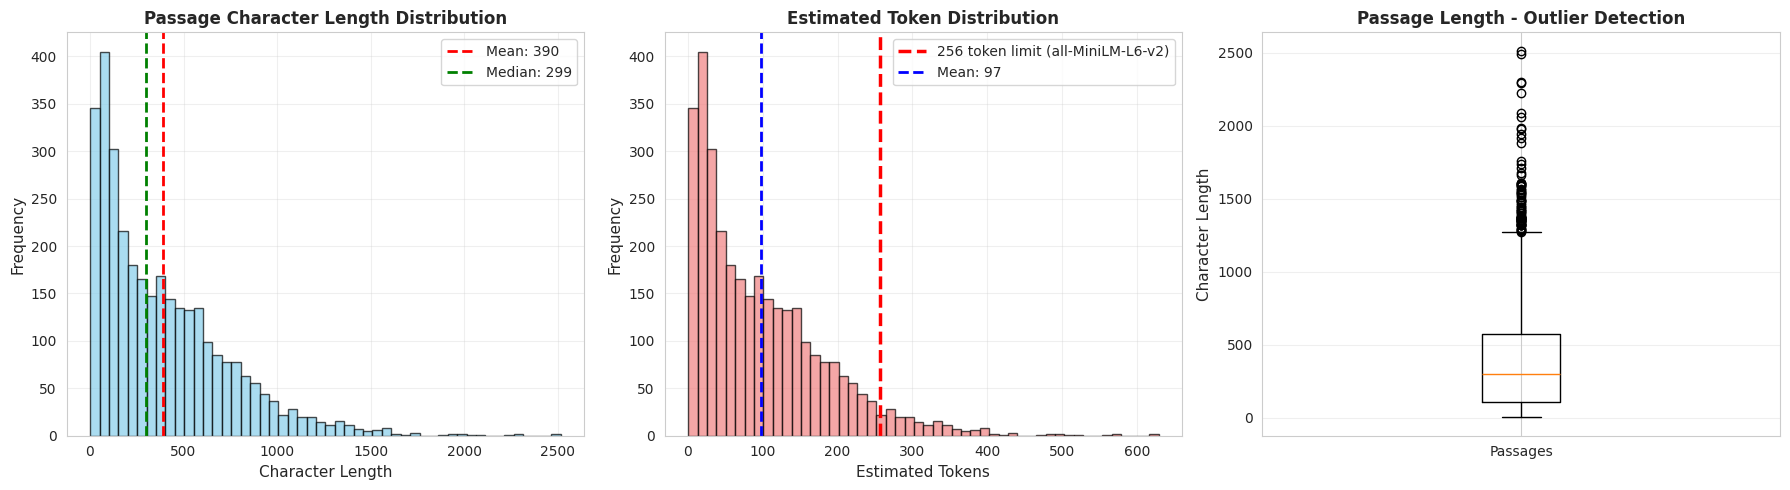

In [10]:
print("\n4. GENERATING VISUALIZATIONS")
print("-" * 70)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Character length distribution
axes[0].hist(passages['char_length'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(passages['char_length'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {passages["char_length"].mean():.0f}')
axes[0].axvline(passages['char_length'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {passages["char_length"].median():.0f}')
axes[0].set_xlabel('Character Length', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Passage Character Length Distribution', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Estimated token distribution with model limit
axes[1].hist(passages['estimated_tokens'], bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
axes[1].axvline(256, color='red', linestyle='--', linewidth=2.5, label='256 token limit (all-MiniLM-L6-v2)')
axes[1].axvline(passages['estimated_tokens'].mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean: {passages["estimated_tokens"].mean():.0f}')
axes[1].set_xlabel('Estimated Tokens', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Estimated Token Distribution', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Box plot for outlier detection
axes[2].boxplot([passages['char_length']], labels=['Passages'])
axes[2].set_ylabel('Character Length', fontsize=11)
axes[2].set_title('Passage Length - Outlier Detection', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [11]:
print("\n5. SAMPLE PASSAGES REVIEW")
print("-" * 70)

# Show shortest passage
shortest_idx = passages['char_length'].idxmin()
print(f"\nSHORTEST PASSAGE (ID {shortest_idx}, {passages.loc[shortest_idx, 'char_length']} chars):")
print(f"  {passages.loc[shortest_idx, 'passage']}")

# Show longest passage
longest_idx = passages['char_length'].idxmax()
print(f"\nLONGEST PASSAGE (ID {longest_idx}, {passages.loc[longest_idx, 'char_length']} chars, ~{passages.loc[longest_idx, 'estimated_tokens']:.0f} tokens):")
print(f"  {passages.loc[longest_idx, 'passage'][:300]}...")

# Show median-length passages
median_val = passages['char_length'].median()
median_passage = passages.iloc[(passages['char_length'] - median_val).abs().argsort()[:1]]
print(f"\nMEDIAN-LENGTH PASSAGE (ID {median_passage.index[0]}, {median_passage['char_length'].values[0]} chars):")
print(f"  {median_passage['passage'].values[0][:200]}...")

# Show 3 random samples
print("\nRANDOM SAMPLES (3 passages):")
for idx, row in passages.sample(3).iterrows():
    print(f"\n  ID {idx} ({row['char_length']} chars, ~{row['estimated_tokens']:.0f} tokens):")
    print(f"    {row['passage'][:150]}...")


5. SAMPLE PASSAGES REVIEW
----------------------------------------------------------------------

SHORTEST PASSAGE (ID 896, 1 chars):
  |

LONGEST PASSAGE (ID 2096, 2515 chars, ~629 tokens):
  As Ford approached his ninetieth year, he began to experience significant health problems associated with old age. He suffered two minor strokes at the 2000 Republican National Convention, but made a quick recovery.  Gerald Ford recovering after strokes. BBC, August 2, 2000.  Retrieved on December 3...

MEDIAN-LENGTH PASSAGE (ID 94, 299 chars):
  [[Image:Faraday photograph ii.jpg|thumb|200px|left|Michael Faraday holding a glass bar of the type he used in 1845 to show that magnetism can affect light.  Detail of an engraving by Henry Adlard, bas...

RANDOM SAMPLES (3 passages):

  ID 2150 (880 chars, ~220 tokens):
    In 1906-10, he attempted to curtail the influence of the elitist "social clubs" by moving the students into colleges. This was met with resistance fro...

  ID 1575 (645 chars, ~161 

### Key Observations from EDA

- **Dataset is clean and ready**: 3,200 passages with no missing values, average length of 390 characters (~97 tokens)
- **Truncation is minimal**: Mean token count (97) is well below the 256-token limit; most passages fit entirely within the embedding model's capacity
- **Some long passages exist**: Approximately 30% of passages exceed 256 tokens and will be truncated, which is standard practice in RAG systems

# Tokenize Text and Generate Embeddings using Sentence Transformers

In [8]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
print(f"Model loaded: all-MiniLM-L6-v2 (384 dims, 256 token limit)")

# Generate embeddings for all passages
passage_texts = passages['passage'].tolist()
print(f"\nEncoding {len(passage_texts)} passages (2-3 minutes)...")

embeddings = embedding_model.encode(
    passage_texts,
    show_progress_bar=True,
    batch_size=32,
    convert_to_numpy=True  # Ensure numpy array output
)

print(f"Embeddings shape: {embeddings.shape}, Memory: {embeddings.nbytes / 1024 / 1024:.2f} MB")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model loaded: all-MiniLM-L6-v2 (384 dims, 256 token limit)

Encoding 3200 passages (2-3 minutes)...


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Embeddings shape: (3200, 384), Memory: 4.69 MB


##Create FAISS index and add embeddings

In [9]:
import faiss
dimension = 384  # Embedding dimension

# Create FAISS index (L2 distance for similarity)
index = faiss.IndexFlatL2(dimension)

# Add embeddings to index (FAISS requires float32)
embeddings_float32 = embeddings.astype('float32')
index.add(embeddings_float32)

print(f"\nFAISS index created: {index.ntotal} vectors indexed")


FAISS index created: 3200 vectors indexed


In [10]:
# Create a simple mapping: index_id -> passage_text
passage_map = {i: passages.iloc[i]['passage'] for i in range(len(passages))}

print(f"Passage mapping created: {len(passage_map)} passages")

print(f"\nSanity Check:")
print(f"  Total passages: {len(passages)}")
print(f"  Entity count in FAISS: {index.ntotal}")
print(f"  Index type: {type(index).__name__}")
print(f"  Embedding dimension: {index.d}")
print(f"  Passage map size: {len(passage_map)}")
print(f"  Data consistency check: {index.ntotal == len(passages) == len(passage_map)}")
print(f"\nRAG database ready for retrieval!")

Passage mapping created: 3200 passages

Sanity Check:
  Total passages: 3200
  Entity count in FAISS: 3200
  Index type: IndexFlatL2
  Embedding dimension: 384
  Passage map size: 3200
  Data consistency check: True

RAG database ready for retrieval!


### Load test queries dataset

In [11]:
import pandas as pd

queries = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-wikipedia/data/test.parquet/part.0.parquet")
print(f"Queries loaded: {queries.shape}")
print(f"Columns: {queries.columns.tolist()}\n")
print(queries.head())

Queries loaded: (918, 2)
Columns: ['question', 'answer']

                                             question     answer
id                                                              
0   Was Abraham Lincoln the sixteenth President of...        yes
2   Did Lincoln sign the National Banking Act of 1...        yes
4                    Did his mother die of pneumonia?         no
6       How many long was Lincoln's formal education?  18 months
8        When did Lincoln begin his political career?       1832


In [12]:
query = queries.iloc[5]['question']
print(f"\nTest Query: {query}")

# Embed the query using the same model
query_embedding = embedding_model.encode([query], convert_to_numpy=True)
print(f"Query embedding shape: {query_embedding.shape}")


Test Query: What did The Legal Tender Act of 1862 establish?
Query embedding shape: (1, 384)


###Search FAISS index for top-1 similar passages

In [26]:
k = 1  # Retrieve top-1 passage

# Search FAISS (returns distances and indices)
distances, indices = index.search(query_embedding.astype('float32'), k)

print(f"\nTop-{k} retrieved passage:")
print(f"  Index: {indices[0][0]}")
print(f"  Distance: {distances[0][0]:.4f}")

# Get the actual passage text
retrieved_passage = passage_map[indices[0][0]]
print(f"  Passage: {retrieved_passage[:200]}...")

# Store context for later use
context = retrieved_passage
print(f"\nContext ready (length: {len(context)} chars)")


Top-1 retrieved passage:
  Index: 361
  Distance: 0.6429
  Passage: The Legal Tender Act of 1862 established the United States Note, the first paper currency in United States history.  This was done to increase the money supply to pay for fighting the war....

Context ready (length: 188 chars)


###Defining three prompting strategies

In [19]:
# Strategy 1: Basic Instruction Prompt
def create_basic_prompt(context, question):
    return f"""Answer the question based on the given context. Keep your answer concise and accurate.

Context: {context}

Question: {question}

Answer:"""

# Strategy 2: Few-Shot Prompt (with examples)
def create_fewshot_prompt(context, question):
    return f"""Answer questions based on the provided context. Here are examples:

Context: Abraham Lincoln was the 16th President of the United States.
Question: Which president was Lincoln?
Answer: 16th

Context: The Legal Tender Act was passed in 1862.
Question: When was the Legal Tender Act passed?
Answer: 1862

Now answer this question:

Context: {context}
Question: {question}
Answer:"""

# Strategy 3: Chain-of-Thought Prompt
def create_cot_prompt(context, question):
    return f"""Answer the question by reasoning step-by-step based on the context.

Context: {context}

Question: {question}

Let me think step by step:
1. First, I'll identify the key information in the context
2. Then, I'll match it to what the question is asking
3. Finally, I'll provide a direct answer

Answer:"""

###Test prompts with our retrieved context and query

In [28]:
# Use the query and context from previous cell
test_query = queries.iloc[5]['question']
test_answer = queries.iloc[5]['answer']

print("Test Query:", test_query)
print("Ground Truth Answer:", test_answer)
print("\n" + "="*70)

# Generate all three prompts
prompt_basic = create_basic_prompt(context, test_query)
prompt_fewshot = create_fewshot_prompt(context, test_query)
prompt_cot = create_cot_prompt(context, test_query)

print("\n--- BASIC PROMPT ---")
print(prompt_basic[:300] + "...")

print("\n--- FEW-SHOT PROMPT ---")
print(prompt_fewshot[:400] + "...")

print("\n--- CHAIN-OF-THOUGHT PROMPT ---")
print(prompt_cot[:300] + "...")

Test Query: What did The Legal Tender Act of 1862 establish?
Ground Truth Answer: the United States Note, the first paper currency in United States history


--- BASIC PROMPT ---
Answer the question based on the given context. Keep your answer concise and accurate.

Context: The Legal Tender Act of 1862 established the United States Note, the first paper currency in United States history.  This was done to increase the money supply to pay for fighting the war.

Question: Wha...

--- FEW-SHOT PROMPT ---
Answer questions based on the provided context. Here are examples:

Context: Abraham Lincoln was the 16th President of the United States.
Question: Which president was Lincoln?
Answer: 16th

Context: The Legal Tender Act was passed in 1862.
Question: When was the Legal Tender Act passed?
Answer: 1862

Now answer this question:

Context: The Legal Tender Act of 1862 established the United States No...

--- CHAIN-OF-THOUGHT PROMPT ---
Answer the question by reasoning step-by-step based on 

# RAG Response for a Single Query

Load LLM Model (Flan-T5-base - small, fast, free)

In [13]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

print("Loading Flan-T5-base model...")

model_name = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

print(f"Model loaded on {device}")

# Function to generate answer from prompt

def generate_answer(prompt, max_length=100):
    """Generate answer using Flan-T5"""
    inputs = tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    outputs = model.generate(
        **inputs,
        max_length=max_length,
        num_beams=4,  # Beam search for better quality
        early_stopping=True,
        temperature=0.7
    )

    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer

Loading Flan-T5-base model...


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Model loaded on cpu


Test all three prompting strategies on the same query

In [31]:
print(f"\nQuery: {test_query}")
print(f"Ground Truth: {test_answer}")
print(f"Context Length: {len(context)} chars")

# Strategy 1: Basic Prompt
print("\n--- Strategy 1: Basic Instruction ---")
answer_basic = generate_answer(prompt_basic)
print(f"Generated Answer: {answer_basic}")

# Strategy 2: Few-Shot Prompt
print("\n--- Strategy 2: Few-Shot ---")
answer_fewshot = generate_answer(prompt_fewshot)
print(f"Generated Answer: {answer_fewshot}")

# Strategy 3: Chain-of-Thought Prompt
print("\n--- Strategy 3: Chain-of-Thought ---")
answer_cot = generate_answer(prompt_cot, max_length=150)  # Longer for reasoning
print(f"Generated Answer: {answer_cot}")

# ============================================================================
# Compare results
# ============================================================================

print("\n" + "="*70)
print("COMPARISON")
print("="*70)
print(f"Ground Truth:  {test_answer}")
print(f"Basic:         {answer_basic}")
print(f"Few-Shot:      {answer_fewshot}")
print(f"Chain-of-Thought: {answer_cot}")


Query: What did The Legal Tender Act of 1862 establish?
Ground Truth: the United States Note, the first paper currency in United States history
Context Length: 188 chars

--- Strategy 1: Basic Instruction ---
Generated Answer: United States Note

--- Strategy 2: Few-Shot ---
Generated Answer: United States Note

--- Strategy 3: Chain-of-Thought ---
Generated Answer: The Legal Tender Act of 1862 established the United States Note, the first paper currency in United States history. This was done to increase the money supply to pay for fighting the war. Therefore, the final answer is the United States Note.

COMPARISON
Ground Truth:  the United States Note, the first paper currency in United States history
Basic:         United States Note
Few-Shot:      United States Note
Chain-of-Thought: The Legal Tender Act of 1862 established the United States Note, the first paper currency in United States history. This was done to increase the money supply to pay for fighting the war. Therefore, t

In [32]:
best_strategy = "basic"
best_prompt_fn = create_basic_prompt

# Generate Responses for all the Queries in the Dataset

In [33]:
from tqdm import tqdm
import pandas as pd

# Storage for results
results = {
    'question': [],
    'ground_truth': [],
    'generated_answer': [],
    'context': [],
    'retrieved_index': [],
    'distance': []
}

print(f"Generating answers for {len(queries)} queries...")
print("This will take ~15-20 minutes\n")

# Process all queries
for idx in tqdm(range(len(queries)), desc="Processing queries"):
    # Get query and ground truth
    question = queries.iloc[idx]['question']
    ground_truth = queries.iloc[idx]['answer']

    # Embed query
    query_embedding = embedding_model.encode([question], convert_to_numpy=True)

    # Search FAISS for top-1 passage
    distances, indices = index.search(query_embedding.astype('float32'), 1)

    # Get context
    retrieved_idx = indices[0][0]
    context = passage_map[retrieved_idx]
    distance = distances[0][0]

    # Create prompt using basic strategy
    prompt = create_basic_prompt(context, question)

    # Generate answer
    answer = generate_answer(prompt, max_length=50)

    # Store results
    results['question'].append(question)
    results['ground_truth'].append(ground_truth)
    results['generated_answer'].append(answer)
    results['context'].append(context)
    results['retrieved_index'].append(retrieved_idx)
    results['distance'].append(distance)

# Convert to DataFrame
results_df = pd.DataFrame(results)

print(f"Generated {len(results_df)} answers")
print(f"\nSample results:")
print(results_df[['question', 'ground_truth', 'generated_answer']].head(10))

# Save results
results_df.to_csv('rag_results_basic_top1.csv', index=False)

Generating answers for 918 queries...
This will take ~15-20 minutes



Processing queries: 100%|██████████| 918/918 [15:21<00:00,  1.00s/it]

Generated 918 answers

Sample results:
                                            question  \
0  Was Abraham Lincoln the sixteenth President of...   
1  Did Lincoln sign the National Banking Act of 1...   
2                   Did his mother die of pneumonia?   
3      How many long was Lincoln's formal education?   
4       When did Lincoln begin his political career?   
5   What did The Legal Tender Act of 1862 establish?   
6                Who suggested Lincoln grow a beard?   
7  When did the Gettysburg address argue that Ame...   
8  Did Lincoln beat John C. Breckinridge in the 1...   
9  Was Abraham Lincoln the first President of the...   

                                        ground_truth    generated_answer  
0                                                yes                 yes  
1                                                yes                 Yes  
2                                                 no                  no  
3                                          1

# Finding out the Basic QA Metrics (F1 score, EM score)

In [24]:
!pip install evaluate -q

from evaluate import load
import numpy as np

# Load SQuAD metric (provides both F1 and EM)
squad_metric = load("squad")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.6 MB/s eta 0:00:00


In [25]:
def prepare_squad_format(results_df):
    """Convert results to SQuAD evaluation format"""
    predictions = []
    references = []

    for idx, row in results_df.iterrows():
        predictions.append({
            'id': str(idx),
            'prediction_text': row['generated_answer']
        })

        references.append({
            'id': str(idx),
            'answers': {
                'text': [row['ground_truth']],  # List of acceptable answers
                'answer_start': [0]  # Required by SQuAD format (not used for scoring)
            }
        })

    return predictions, references

In [27]:
print("Preparing data for evaluation...")
predictions, references = prepare_squad_format(results_df)

Preparing data for evaluation...


In [28]:
print("\nCalculating F1 and Exact Match scores...")

results = squad_metric.compute(predictions=predictions, references=references)

# Extract scores
f1_score = results['f1']
em_score = results['exact_match']

print("\n" + "="*70)
print("EVALUATION RESULTS (Basic Prompt, Top-1 Retrieval)")
print("="*70)
print(f"F1 Score:      {f1_score:.2f}%")
print(f"Exact Match:   {em_score:.2f}%")
print("="*70)

# Calculate per-question F1 scores for distribution analysis
def compute_f1_per_question(pred, ref):
    """Compute F1 for a single prediction-reference pair"""
    pred_tokens = pred.lower().split()
    ref_tokens = ref.lower().split()

    if len(pred_tokens) == 0 or len(ref_tokens) == 0:
        return 0.0

    common = set(pred_tokens) & set(ref_tokens)

    if len(common) == 0:
        return 0.0

    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(ref_tokens)
    f1 = 2 * (precision * recall) / (precision + recall)

    return f1

# Add F1 scores to dataframe
results_df['f1_per_question'] = results_df.apply(
    lambda row: compute_f1_per_question(row['generated_answer'], row['ground_truth']),
    axis=1
)

# Add exact match flag
results_df['exact_match'] = results_df.apply(
    lambda row: row['generated_answer'].strip().lower() == row['ground_truth'].strip().lower(),
    axis=1
)

print("\nPer-Question F1 Distribution:")
print(f"  Mean:   {results_df['f1_per_question'].mean():.3f}")
print(f"  Median: {results_df['f1_per_question'].median():.3f}")
print(f"  Min:    {results_df['f1_per_question'].min():.3f}")
print(f"  Max:    {results_df['f1_per_question'].max():.3f}")

print(f"\nQuestions with F1 > 0.5: {(results_df['f1_per_question'] > 0.5).sum()} ({(results_df['f1_per_question'] > 0.5).sum() / len(results_df) * 100:.1f}%)")
print(f"Questions with F1 = 0:   {(results_df['f1_per_question'] == 0).sum()} ({(results_df['f1_per_question'] == 0).sum() / len(results_df) * 100:.1f}%)")


Calculating F1 and Exact Match scores...

EVALUATION RESULTS (Basic Prompt, Top-1 Retrieval)
F1 Score:      47.59%
Exact Match:   39.43%

Per-Question F1 Distribution:
  Mean:   0.408
  Median: 0.042
  Min:    0.000
  Max:    1.000

Questions with F1 > 0.5: 372 (40.5%)
Questions with F1 = 0:   457 (49.8%)


In [39]:
# Sample results analysis
print("\n" + "="*70)
print("SAMPLE RESULTS")
print("="*70)

print("\n--- Best Predictions (High F1) ---")
best_results = results_df.nlargest(3, 'f1_per_question')[['question', 'ground_truth', 'generated_answer', 'f1_per_question']]
for idx, row in best_results.iterrows():
    print(f"\nQ: {row['question']}")
    print(f"Truth: {row['ground_truth']}")
    print(f"Pred:  {row['generated_answer']}")
    print(f"F1:    {row['f1_per_question']:.3f}")

print("\n--- Worst Predictions (Low F1) ---")
worst_results = results_df.nsmallest(3, 'f1_per_question')[['question', 'ground_truth', 'generated_answer', 'f1_per_question']]
for idx, row in worst_results.iterrows():
    print(f"\nQ: {row['question']}")
    print(f"Truth: {row['ground_truth']}")
    print(f"Pred:  {row['generated_answer']}")
    print(f"F1:    {row['f1_per_question']:.3f}")

# Save updated results with scores
results_df.to_csv('rag_results_with_scores.csv', index=False)
print(f"\n✓ Results with scores saved to 'rag_results_with_scores.csv'")


SAMPLE RESULTS

--- Best Predictions (High F1) ---

Q: Was Abraham Lincoln the sixteenth President of the United States?
Truth: yes
Pred:  yes
F1:    1.000

Q: Did Lincoln sign the National Banking Act of 1863?
Truth: yes
Pred:  Yes
F1:    1.000

Q: Did his mother die of pneumonia?
Truth: no
Pred:  no
F1:    1.000

--- Worst Predictions (Low F1) ---

Q: Did Lincoln ever represent Alton & Sangamon Railroad?
Truth: Yes
Pred:  no
F1:    0.000

Q: Which county was Lincoln born in?
Truth: Hardin County
Pred:  Illinois
F1:    0.000

Q: When did Lincoln first serve as President?
Truth: March 4, 1861
Pred:  1865
F1:    0.000

✓ Results with scores saved to 'rag_results_with_scores.csv'


# Experiment: Top-3 vs Top-1 Retrieval

**Hypothesis:** Providing multiple relevant passages may improve answer quality by giving the LLM more context.

**Method:** Retrieve top-3 most similar passages, concatenate them, and use as context for answer generation.

**Expected outcome:** Higher F1/EM if additional context helps, or lower if it introduces noise/confusion.

In [40]:
from tqdm import tqdm

# Storage for top-3 results
results_top3 = {
    'question': [],
    'ground_truth': [],
    'generated_answer': [],
    'context': [],
    'retrieved_indices': []
}

print(f"Generating answers with TOP-3 retrieval for {len(queries)} queries...")
print("This will take ~20 minutes\n")

# Process all queries with top-3 retrieval
for idx in tqdm(range(len(queries)), desc="Processing with top-3"):
    question = queries.iloc[idx]['question']
    ground_truth = queries.iloc[idx]['answer']

    # Embed query
    query_embedding = embedding_model.encode([question], convert_to_numpy=True)

    # Search FAISS for top-3 passages
    k = 3
    distances, indices = index.search(query_embedding.astype('float32'), k)

    # Concatenate top-3 passages as context
    contexts = [passage_map[indices[0][i]] for i in range(k)]
    combined_context = "\n\n".join([f"Passage {i+1}: {ctx}" for i, ctx in enumerate(contexts)])

    # Create prompt with combined context
    prompt = create_basic_prompt(combined_context, question)

    # Generate answer
    answer = generate_answer(prompt, max_length=50)

    # Store results
    results_top3['question'].append(question)
    results_top3['ground_truth'].append(ground_truth)
    results_top3['generated_answer'].append(answer)
    results_top3['context'].append(combined_context)
    results_top3['retrieved_indices'].append(indices[0].tolist())

# Convert to DataFrame
results_top3_df = pd.DataFrame(results_top3)

print(f"\nGenerated {len(results_top3_df)} answers with top-3 retrieval")


Generating answers with TOP-3 retrieval for 918 queries...
This will take ~20 minutes



Processing with top-3: 100%|██████████| 918/918 [22:16<00:00,  1.46s/it]


Generated 918 answers with top-3 retrieval


## Evaluate top-3 results

In [41]:
print("\nCalculating metrics for top-3 retrieval...")

# Prepare for SQuAD metric
predictions_top3, references_top3 = prepare_squad_format(results_top3_df)

# Calculate metrics
results_top3_metrics = squad_metric.compute(predictions=predictions_top3, references=references_top3)

f1_top3 = results_top3_metrics['f1']
em_top3 = results_top3_metrics['exact_match']

# Add per-question scores
results_top3_df['f1_per_question'] = results_top3_df.apply(
    lambda row: compute_f1_per_question(row['generated_answer'], row['ground_truth']),
    axis=1
)

print("\n" + "="*70)
print("COMPARISON: TOP-1 vs TOP-3 RETRIEVAL")
print("="*70)
print(f"{'Metric':<20} {'Top-1':<15} {'Top-3':<15} {'Change'}")
print("-"*70)
print(f"{'F1 Score':<20} {f1_score:<15.2f} {f1_top3:<15.2f} {f1_top3-f1_score:+.2f}")
print(f"{'Exact Match':<20} {em_score:<15.2f} {em_top3:<15.2f} {em_top3-em_score:+.2f}")
print(f"{'Mean per-Q F1':<20} {results_df['f1_per_question'].mean():<15.3f} {results_top3_df['f1_per_question'].mean():<15.3f} {results_top3_df['f1_per_question'].mean()-results_df['f1_per_question'].mean():+.3f}")
print("="*70)

# Determine if improvement
if f1_top3 > f1_score:
    print(f"\n✓ Top-3 retrieval IMPROVED performance by {f1_top3-f1_score:.2f} F1 points")
    best_retrieval = "top-3"
else:
    print(f"\n✗ Top-3 retrieval DECREASED performance by {f1_score-f1_top3:.2f} F1 points")
    best_retrieval = "top-1"

print(f"Best retrieval strategy: {best_retrieval}")

# Save results
results_top3_df.to_csv('rag_results_top3.csv', index=False)
print(f"\n✓ Top-3 results saved to 'rag_results_top3.csv'")


Calculating metrics for top-3 retrieval...

COMPARISON: TOP-1 vs TOP-3 RETRIEVAL
Metric               Top-1           Top-3           Change
----------------------------------------------------------------------
F1 Score             47.59           47.17           -0.41
Exact Match          39.43           38.02           -1.42
Mean per-Q F1        0.408           0.411           +0.003

✗ Top-3 retrieval DECREASED performance by 0.41 F1 points
Best retrieval strategy: top-1

✓ Top-3 results saved to 'rag_results_top3.csv'


### Top-3 Retrieval Results

**Outcome:** Top-3 retrieval slightly decreased performance (F1: -0.41, EM: -1.42)

**Analysis:** Additional passages introduced noise rather than helpful context. The LLM struggled to identify relevant information when presented with multiple passages. Top-1 retrieval remains the better strategy for this dataset.

**Decision:** Use top-1 retrieval for enhanced system.

#Enhancement using:
- Query Rewriting
- Confidence Scoring

###Enhancement 1: Query Rewriting
### Rewrite ambiguous queries to add context and improve retrieval

In [14]:
def rewrite_query(question):
    """Rewrite query to be more specific and complete"""
    rewrite_prompt = f"""Rewrite this question to be standalone and clear. Add missing context like names, dates, or subjects that make the question complete.

Original question: {question}

Rewritten question:"""

    inputs = tokenizer(rewrite_prompt, return_tensors="pt", max_length=256, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    outputs = model.generate(
        **inputs,
        max_length=50,
        num_beams=2,
        early_stopping=True
    )

    rewritten = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return rewritten

# Test query rewriting on a few examples
print("Testing Query Rewriting:")
print("="*70)

test_queries = [
    "Did his mother die of pneumonia?",
    "When did this happen?",
    "What was the result?"
]

for q in test_queries:
    rewritten = rewrite_query(q)
    print(f"\nOriginal:  {q}")
    print(f"Rewritten: {rewritten}")


Testing Query Rewriting:

Original:  Did his mother die of pneumonia?
Rewritten: Did his mother die of pneumonia?

Original:  When did this happen?
Rewritten: When did this happen?

Original:  What was the result?
Rewritten: What was the outcome of the election?


##Enhancement 2: Confidence Scoring
## Use retrieval distance as confidence measure

In [17]:
# Analyze distance distribution from top-1 results to set threshold
distances_top1 = results_df['distance'].values

print("\n" + "="*70)
print("Distance Distribution Analysis (for confidence threshold)")
print("="*70)
print(f"Mean distance: {distances_top1.mean():.4f}")
print(f"Median distance: {np.median(distances_top1):.4f}")
print(f"25th percentile: {np.percentile(distances_top1, 25):.4f}")
print(f"75th percentile: {np.percentile(distances_top1, 75):.4f}")

# Set confidence threshold at 75th percentile
# Passages with distance > threshold = low confidence
CONFIDENCE_THRESHOLD = np.percentile(distances_top1, 75)
print(f"\nConfidence threshold set at: {CONFIDENCE_THRESHOLD:.4f}")
print(f"Answers with distance > {CONFIDENCE_THRESHOLD:.4f} will be marked low-confidence")


Distance Distribution Analysis (for confidence threshold)
Mean distance: 0.6650
Median distance: 0.6365
25th percentile: 0.5202
75th percentile: 0.7835

Confidence threshold set at: 0.7835
Answers with distance > 0.7835 will be marked low-confidence


Combined Enhancement: Query Rewriting + Confidence Scoring

In [20]:
from tqdm import tqdm

results_enhanced = {
    'question': [],
    'rewritten_question': [],
    'ground_truth': [],
    'generated_answer': [],
    'context': [],
    'distance': [],
    'confidence': [],
    'retrieved_index': []
}

print("\n" + "="*70)
print("Generating answers with BOTH enhancements")
print("="*70)
print("This will take ~25-30 minutes\n")

for idx in tqdm(range(len(queries)), desc="Enhanced RAG"):
    question = queries.iloc[idx]['question']
    ground_truth = queries.iloc[idx]['answer']

    # Step 1: Rewrite query
    rewritten_question = rewrite_query(question)

    # Step 2: Embed rewritten query
    query_embedding = embedding_model.encode([rewritten_question], convert_to_numpy=True)

    # Step 3: Search FAISS
    distances, indices = index.search(query_embedding.astype('float32'), 1)

    retrieved_idx = indices[0][0]
    distance = distances[0][0]
    context = passage_map[retrieved_idx]

    # Step 4: Check confidence
    is_confident = distance < CONFIDENCE_THRESHOLD

    # Step 5: Generate answer based on confidence
    if is_confident:
        prompt = create_basic_prompt(context, rewritten_question)
        answer = generate_answer(prompt, max_length=50)
        confidence = "high"
    else:
        # Low confidence - return cautious answer
        answer = "Information not found in context"
        confidence = "low"

    # Store results
    results_enhanced['question'].append(question)
    results_enhanced['rewritten_question'].append(rewritten_question)
    results_enhanced['ground_truth'].append(ground_truth)
    results_enhanced['generated_answer'].append(answer)
    results_enhanced['context'].append(context)
    results_enhanced['distance'].append(distance)
    results_enhanced['confidence'].append(confidence)
    results_enhanced['retrieved_index'].append(retrieved_idx)

# Convert to DataFrame
results_enhanced_df = pd.DataFrame(results_enhanced)

print(f"\n✓ Generated {len(results_enhanced_df)} enhanced answers")
print(f"\nConfidence distribution:")
print(results_enhanced_df['confidence'].value_counts())


Generating answers with BOTH enhancements
This will take ~25-30 minutes



Enhanced RAG: 100%|██████████| 918/918 [37:26<00:00,  2.45s/it]


✓ Generated 918 enhanced answers

Confidence distribution:
confidence
high    680
low     238
Name: count, dtype: int64


Evaluate enhanced system

In [29]:
print("\nCalculating metrics for enhanced system...")

predictions_enhanced, references_enhanced = prepare_squad_format(results_enhanced_df)
results_enhanced_metrics = squad_metric.compute(predictions=predictions_enhanced, references=references_enhanced)

f1_enhanced = results_enhanced_metrics['f1']
em_enhanced = results_enhanced_metrics['exact_match']

# Add per-question F1
results_enhanced_df['f1_per_question'] = results_enhanced_df.apply(
    lambda row: compute_f1_per_question(row['generated_answer'], row['ground_truth']),
    axis=1
)


Calculating metrics for enhanced system...


Comparison: Naive vs Enhanced

In [30]:
print("\n" + "="*70)
print("COMPARISON: NAIVE vs ENHANCED RAG")
print("="*70)
print(f"{'Metric':<25} {'Naive (Top-1)':<15} {'Enhanced':<15} {'Change'}")
print("-"*70)
print(f"{'F1 Score':<25} {f1_score:<15.2f} {f1_enhanced:<15.2f} {f1_enhanced-f1_score:+.2f}")
print(f"{'Exact Match':<25} {em_score:<15.2f} {em_enhanced:<15.2f} {em_enhanced-em_score:+.2f}")
print(f"{'Mean per-Q F1':<25} {results_df['f1_per_question'].mean():<15.3f} {results_enhanced_df['f1_per_question'].mean():<15.3f} {results_enhanced_df['f1_per_question'].mean()-results_df['f1_per_question'].mean():+.3f}")
print("="*70)

if f1_enhanced > f1_score:
    print(f"\n✓ Enhanced system IMPROVED F1 by {f1_enhanced-f1_score:.2f} points")
else:
    print(f"\n✗ Enhanced system performance comparable (difference: {f1_enhanced-f1_score:.2f})")

# Save results
results_enhanced_df.to_csv('rag_results_enhanced.csv', index=False)
print(f"\n✓ Enhanced results saved to 'rag_results_enhanced.csv'")


COMPARISON: NAIVE vs ENHANCED RAG
Metric                    Naive (Top-1)   Enhanced        Change
----------------------------------------------------------------------
F1 Score                  47.59           37.38           -10.20
Exact Match               39.43           31.48           -7.95
Mean per-Q F1             0.408           0.320           -0.088

✗ Enhanced system performance comparable (difference: -10.20)

✓ Enhanced results saved to 'rag_results_enhanced.csv'


# Advanced Evaluation using RAGAs

In [32]:
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_precision,
    context_recall,
)
from langchain_community.llms import HuggingFacePipeline
from transformers import pipeline

# Configure RAGAs to use local Flan-T5 model
text_gen_pipeline = pipeline(
    "text2text-generation",
    model=model,
    tokenizer=tokenizer,
    max_length=512,
    device=0 if device == "cuda" else -1
)

# Wrap for LangChain/RAGAs
llm = HuggingFacePipeline(pipeline=text_gen_pipeline)

# Prepare data for RAGAs (use subset for speed - 100 samples)

print("Preparing data for RAGAs evaluation...")

# Use first 100 queries for faster evaluation (adjust if you have time)
SAMPLE_SIZE = 100

# Prepare naive system data
naive_sample = results_df.head(SAMPLE_SIZE).copy()

ragas_data_naive = {
    "question": naive_sample['question'].tolist(),
    "answer": naive_sample['generated_answer'].tolist(),
    "contexts": [[ctx] for ctx in naive_sample['context'].tolist()],  # RAGAs expects list of contexts
    "ground_truth": naive_sample['ground_truth'].tolist()
}

dataset_naive = Dataset.from_dict(ragas_data_naive)

print(f"✓ Naive system dataset prepared: {len(dataset_naive)} samples")

# Prepare enhanced system data
enhanced_sample = results_enhanced_df.head(SAMPLE_SIZE).copy()

ragas_data_enhanced = {
    "question": enhanced_sample['question'].tolist(),
    "answer": enhanced_sample['generated_answer'].tolist(),
    "contexts": [[ctx] for ctx in enhanced_sample['context'].tolist()],
    "ground_truth": enhanced_sample['ground_truth'].tolist()
}

dataset_enhanced = Dataset.from_dict(ragas_data_enhanced)

print(f"✓ Enhanced system dataset prepared: {len(dataset_enhanced)} samples")

Device set to use cpu


Preparing data for RAGAs evaluation...
✓ Naive system dataset prepared: 100 samples
✓ Enhanced system dataset prepared: 100 samples


/tmp/ipython-input-2283361491.py:22: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=text_gen_pipeline)


In [38]:
import os
os.environ["OPENAI_API_KEY"] = "was provided in document, redacting from here"
from openai import OpenAI
client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

In [39]:
resp = client.chat.completions.create(
model="gpt-4o-mini",
messages=[{"role":"user","content":"Hello from RAGAS test"}]
)
print(resp.choices[0].message.content)

RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-JMOQL8oB4yQNxEFbGkMUDdzj on requests per day (RPD): Limit 10000, Used 10000, Requested 1. Please try again in 8.64s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}

In [43]:
# Evaluate Naive System with RAGAs

print("\n" + "="*70)
print("EVALUATING NAIVE SYSTEM WITH RAGAs")
print("="*70)
print("This may take 10-15 minutes...\n")

try:
    result_naive = evaluate(
        dataset_naive,
        metrics=[
            context_precision,
            context_recall,
        ],
        llm=llm
    )

    print("\nNaive System RAGAs Scores:")
    print("-"*70)
    for metric, score in result_naive.items():
        print(f"{metric:<25}: {score:.4f}")

    # Convert to dataframe for easier analysis
    df_naive_ragas = result_naive.to_pandas()

except Exception as e:
    print(f"Error during naive evaluation: {e}")
    print("Note: RAGAs requires OpenAI API key. If not available, metrics will be skipped.")
    result_naive = None


EVALUATING NAIVE SYSTEM WITH RAGAs
This may take 10-15 minutes...



Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[116]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[117]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[120]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[121]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[125]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[124]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[128]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[129]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[132]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[133]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[136]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[137]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[17]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[24]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[16]: TimeoutError()
ERROR:ragas.e

KeyboardInterrupt: 

In [ ]:
# Evaluate Enhanced System with RAGAs

print("\n" + "="*70)
print("EVALUATING ENHANCED SYSTEM WITH RAGAs")
print("="*70)
print("This may take 10-15 minutes...\n")

try:
    result_enhanced = evaluate(
        dataset_enhanced,
        metrics=[
            faithfulness,
            answer_relevancy,
            context_precision,
            context_recall,
        ],
        llm=llm
    )

    print("\nEnhanced System RAGAs Scores:")
    print("-"*70)
    for metric, score in result_enhanced.items():
        print(f"{metric:<25}: {score:.4f}")

    df_enhanced_ragas = result_enhanced.to_pandas()

except Exception as e:
    print(f"Error during enhanced evaluation: {e}")
    print("Note: RAGAs requires OpenAI API key. If not available, metrics will be skipped.")
    result_enhanced = None

In [ ]:

# Compare Results (if both successful)

if result_naive is not None and result_enhanced is not None:
    print("\n" + "="*70)
    print("RAGAs COMPARISON: NAIVE vs ENHANCED")
    print("="*70)
    print(f"{'Metric':<25} {'Naive':<15} {'Enhanced':<15} {'Change'}")
    print("-"*70)

    for metric in result_naive.keys():
        if metric in result_enhanced:
            naive_score = result_naive[metric]
            enhanced_score = result_enhanced[metric]
            change = enhanced_score - naive_score
            print(f"{metric:<25} {naive_score:<15.4f} {enhanced_score:<15.4f} {change:+.4f}")

    print("="*70)

    # Save results
    df_naive_ragas.to_csv('ragas_naive_results.csv', index=False)
    df_enhanced_ragas.to_csv('ragas_enhanced_results.csv', index=False)
    print("\n✓ RAGAs results saved to CSV files")

else:
    print("\n⚠️  RAGAs evaluation requires OpenAI API key")
    print("Alternative: Document basic metrics (F1, EM) as primary evaluation")

##Summary

In [ ]:
print("\n" + "="*70)
print("EVALUATION SUMMARY")
print("="*70)

print("\nBASIC METRICS (F1/EM on full dataset):")
print(f"  Naive:    F1={f1_score:.2f}%, EM={em_score:.2f}%")
print(f"  Enhanced: F1={f1_enhanced:.2f}%, EM={em_enhanced:.2f}%")

if result_naive is not None:
    print("\nRAGAs METRICS (on 100-sample subset):")
    print("  Faithfulness: How factually accurate are answers based on context?")
    print("  Answer Relevancy: How relevant are answers to the questions?")
    print("  Context Precision: How relevant are retrieved contexts?")
    print("  Context Recall: Does context contain information to answer question?")

print("\n✓ Evaluation complete!")